In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Add project root to Python path
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root_dir not in sys.path:
    sys.path.insert(0, root_dir)

In [2]:
from langchain_mcp_adapters.client import MultiServerMCPClient

client = MultiServerMCPClient({
    "output_handling":{"image":"content"},
    "use_standard_content_blocks": True,
    "mouse": {
        "transport": "streamable_http",
        "url": "http://localhost:8001/mouse/mcp",
    },
    "gamepad": {
        "transport": "streamable_http",
        "url": "http://localhost:8001/gamepad/mcp"
    }
})

tools = await client.get_tools(server_name="mouse")
screen_tool = None
locate_tool = None
for t in tools:
    print(t.name, t.description)
    if t.name == "get_screen":
        screen_tool = t
    if t.name == "locate_element":
        locate_tool = t

/home/javi/miniconda3/envs/jokernet/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


locate_element Locate UI elements on the screen using a brief text description and computer vision.

This function uses the AskUI PTA-1 model to detect UI elements and automatically calculates
optimal click positions. Always use this function before clicking to ensure accurate targeting.

Parameters
----------
description : str
    Brief, clear description of the UI element to locate.
    Examples: "Select button", "Big Blind", "Run Info", "Options button", "Skip Blind"
    Be specific but concise - focus on distinctive visual features.
    
Returns
-------
dict
    Detection result with the following structure:
    {
        "status": "success" | "error",
        "result": {
            "<OPEN_VOCABULARY_DETECTION>": {
                "bboxes": [],  # List of bounding boxes (if any): [[x1, y1, x2, y2], ...]
                "bboxes_labels": [],  # Labels for each bounding box
                "polygons": [[[x1, y1, x2, y2, x3, y3, x4, y4, ...]]],  # List of polygons
                "pol

In [3]:
import requests
from fastmcp.utilities.types import Image

res = requests.get("http://localhost:8000/screenshot")
display(Image(data=res.content, format="png"))

In [ ]:
async def visualize_element_detection(description, show_comparison=True, figsize=(12, 8)):
    """
    Visualize the detection of an element on the screen and show the calculated click point.
    
    Args:
        description (str): Description of the element to search for
        show_comparison (bool): Whether to show the comparison of center calculation methods
        figsize (tuple): Figure size (width, height)
    
    Returns:
        dict: Detection result with click_positions included
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from PIL import Image
    import requests
    import numpy as np
    import io
    import json
    from matplotlib.lines import Line2D
    
    try:
        # Get the element detection
        location_result = json.loads(await locate_tool.arun({"description": description}))
        print(location_result)
        
        if location_result['status'] != 'success':
            print(f"Error detecting the element: {location_result.get('message', 'Unknown error')}")
            return location_result
        
        detection = location_result['result']['<OPEN_VOCABULARY_DETECTION>']
        
        # Check if elements were found
        if not detection['polygons'] and not detection['bboxes']:
            print(f"No elements found for description: '{description}'")
            return location_result
        
        # Get the image
        res = requests.get("http://localhost:8000/screenshot")
        image = Image.open(io.BytesIO(res.content))
        
        # Create the figure
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax.imshow(image)
        
        # Process polygons if they exist
        if detection['polygons']:
            for i, (polygon_data, label) in enumerate(zip(detection['polygons'], detection['polygons_labels'])):
                # Convert polygon coordinates
                coords = np.array(polygon_data[0]).reshape(-1, 2)
                
                # Create the polygon
                color = plt.cm.Set1(i % 9)  # Use different colors for multiple elements
                polygon = patches.Polygon(coords, linewidth=3, edgecolor=color, facecolor='none', linestyle='-')
                ax.add_patch(polygon)
                
                # Add click point if it exists
                if 'click_positions' in detection and i < len(detection['click_positions']):
                    click_pos = detection['click_positions'][i]
                    if click_pos:
                        click_x, click_y = click_pos['x'], click_pos['y']
                        ax.plot(click_x, click_y, 'x', color=color, markersize=10, markeredgewidth=3)
        
        # Process bboxes if they exist and there are no polygons
        elif detection['bboxes']:
            for i, (bbox_data, label) in enumerate(zip(detection['bboxes'], detection['bboxes_labels'])):
                # Create rectangle from bbox [x1, y1, x2, y2]
                x1, y1, x2, y2 = bbox_data
                width, height = x2 - x1, y2 - y1
                
                color = plt.cm.Set1(i % 9)
                rect = patches.Rectangle((x1, y1), width, height, linewidth=3, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                
                # Add click point if it exists
                if 'click_positions' in detection and i < len(detection['click_positions']):
                    click_pos = detection['click_positions'][i]
                    if click_pos:
                        click_x, click_y = click_pos['x'], click_pos['y']
                        ax.plot(click_x, click_y, 'x', color=color, markersize=10, markeredgewidth=3)
        
        # Set axes
        ax.set_xlim(0, image.width)
        ax.set_ylim(image.height, 0)  # Invert Y axis
        ax.set_title(f'Detection: "{description}"', fontsize=14)
        ax.axis('on')
        
        # Create dynamic legend
        legend_elements = []
        
        # Add polygon elements
        if detection['polygons']:
            for i, label in enumerate(detection['polygons_labels']):
                color = plt.cm.Set1(i % 9)
                legend_elements.append(Line2D([0], [0], color=color, linewidth=3, label=f'Element: {label}'))
                
                if 'click_positions' in detection and i < len(detection['click_positions']):
                    click_pos = detection['click_positions'][i]
                    if click_pos:
                        legend_elements.append(Line2D([0], [0], marker='x', color=color, markersize=8, 
                                                    label=f'Click: ({click_pos["x"]}, {click_pos["y"]})'))
        
        # Add bbox elements
        elif detection['bboxes']:
            for i, label in enumerate(detection['bboxes_labels']):
                color = plt.cm.Set1(i % 9)
                legend_elements.append(Line2D([0], [0], color=color, linewidth=3, label=f'Element: {label}'))
                
                if 'click_positions' in detection and i < len(detection['click_positions']):
                    click_pos = detection['click_positions'][i]
                    if click_pos:
                        legend_elements.append(Line2D([0], [0], marker='x', color=color, markersize=8, 
                                                    label=f'Click: ({click_pos["x"]}, {click_pos["y"]})'))
        
        if legend_elements:
            ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98), 
                     fancybox=True, shadow=True, fontsize=10)
        
        # Show information
        print(f"Elements detected for '{description}':")
        if detection['polygons']:
            print(f"- {len(detection['polygons'])} polygon(s)")
            for i, label in enumerate(detection['polygons_labels']):
                print(f"  • {label}")
                if 'click_positions' in detection and i < len(detection['click_positions']):
                    click_pos = detection['click_positions'][i]
                    if click_pos:
                        print(f"    Click point: ({click_pos['x']}, {click_pos['y']})")
        
        if detection['bboxes']:
            print(f"- {len(detection['bboxes'])} bbox(s)")
            for i, label in enumerate(detection['bboxes_labels']):
                print(f"  • {label}")
                if 'click_positions' in detection and i < len(detection['click_positions']):
                    click_pos = detection['click_positions'][i]
                    if click_pos:
                        print(f"    Click point: ({click_pos['x']}, {click_pos['y']})")
        
        print(f"Image dimensions: {image.width} x {image.height}")
        
        # Show comparison if requested and there is data
        if show_comparison and detection['polygons']:
            polygon_data = detection['polygons'][0][0]
            coords = np.array(polygon_data).reshape(-1, 2)
            center_x_numpy = np.mean(coords[:, 0])
            center_y_numpy = np.mean(coords[:, 1])
            
            if 'click_positions' in detection and detection['click_positions'][0]:
                click_pos = detection['click_positions'][0]
                print(f"\nComparison of center calculation methods:")
                print(f"Center (NumPy): ({center_x_numpy:.1f}, {center_y_numpy:.1f})")
                print(f"Center (MCP Server): ({click_pos['x']}, {click_pos['y']})")
                print(f"Difference: ({abs(center_x_numpy - click_pos['x']):.1f}, {abs(center_y_numpy - click_pos['y']):.1f})")
        
        plt.tight_layout()
        plt.show()
        
        return location_result
        
    except Exception as e:
        print(f"Error in visualization: {str(e)}")
        return {"status": "error", "message": str(e)}

{'status': 'success', 'result': {'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [], 'bboxes_labels': [], 'polygons': [[[89.27999877929688, 85.86000061035156, 490.55999755859375, 85.86000061035156, 490.55999755859375, 148.5, 89.27999877929688, 148.5]]], 'polygons_labels': ['small blind button'], 'click_positions': [{'x': 289, 'y': 117}]}}}
Elementos detectados para 'small blind button':
- 1 polígono(s)
  • small blind button
    Punto de clic: (289, 117)
Dimensiones de la imagen: 1920 x 1080

Comparación de métodos de cálculo del centro:
Centro (NumPy): (289.9, 117.2)
Centro (Servidor MCP): (289, 117)
Diferencia: (0.9, 0.2)


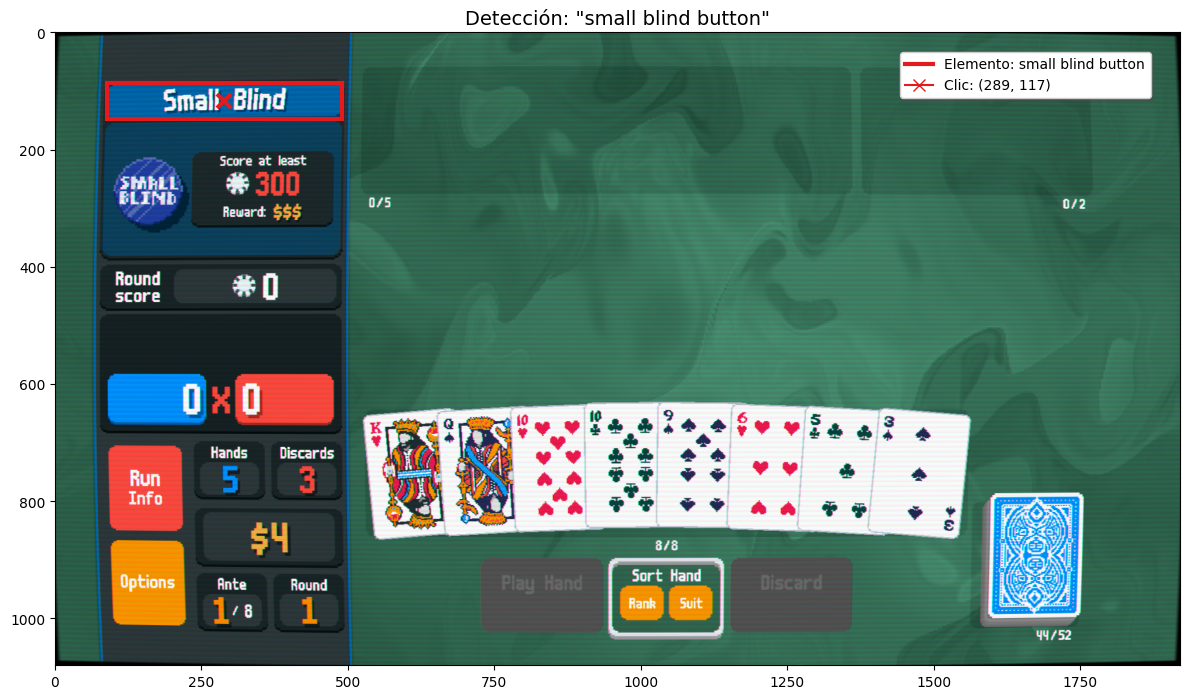

In [ ]:
# Examples of using the visualize_element_detection function

# Search for the 10 of clubs button
result = await visualize_element_detection("small blind button")

{'status': 'success', 'result': {'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [], 'bboxes_labels': [], 'polygons': [[[93.1199951171875, 705.780029296875, 216.0, 705.780029296875, 216.0, 849.4200439453125, 93.1199951171875, 849.4200439453125]]], 'polygons_labels': ['Run Info'], 'click_positions': [{'x': 154, 'y': 777}]}}}
Elementos detectados para 'Run Info':
- 1 polígono(s)
  • Run Info
    Punto de clic: (154, 777)
Dimensiones de la imagen: 1920 x 1080


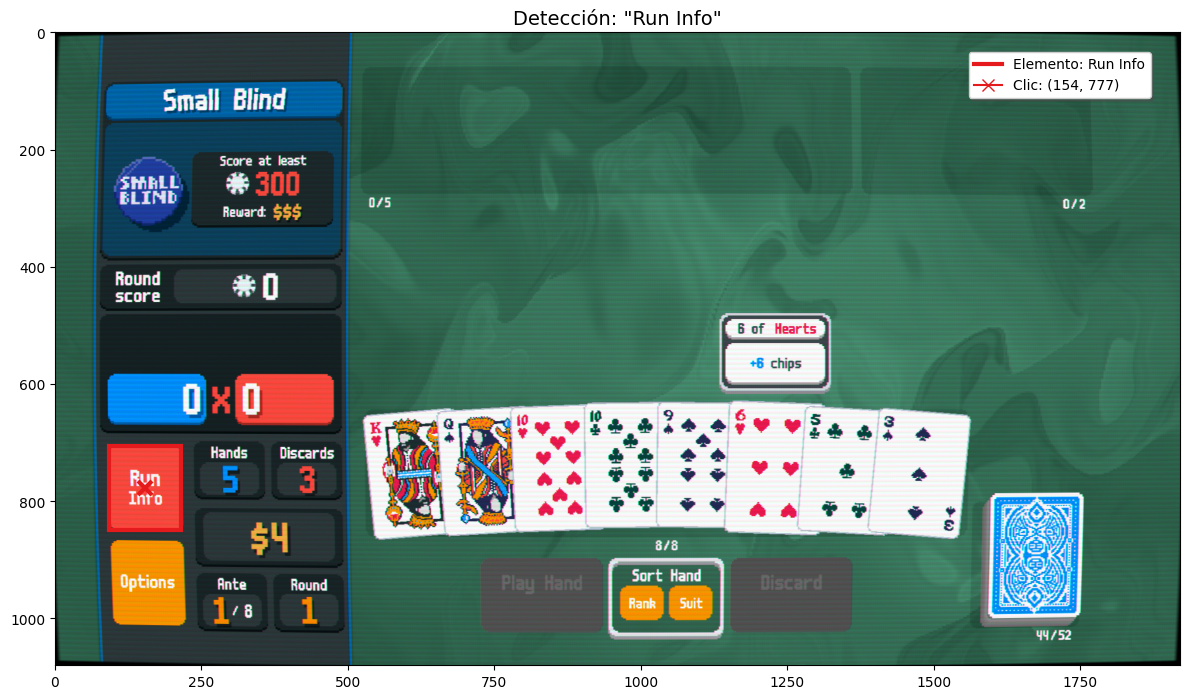

In [6]:
# Probar con otros elementos
result_run_info = await visualize_element_detection("Run Info", show_comparison=False)